In [1]:
!pip install -q segmentation-models-pytorch==0.3.3 timm==0.9.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 84.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

ROOT = "/content/drive/MyDrive/Kuliah/Skripsi S1"
TRAIN_PATH = os.path.join(ROOT, "train/images")
TRAIN_MASK_PATH = os.path.join(ROOT, "train/targets")

TEST_PATH = os.path.join(ROOT, "test/images")
TEST_MASK_PATH = os.path.join(ROOT, "test/targets")

IMG_SIZE = 512
BATCH_SIZE = 8
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3

DEVICE: cuda


In [ ]:
class BuildingDataset(Dataset):
  def __init__(self, image_ids, images_dir, masks_dir, transform=None):
    self.image_ids = image_ids
    self.image_dir = images_dir
    self.mask_dir = masks_dir
    self.transform = transform

  def __len__(self):
    return len(self.image_ids)

  def __getitem__(self, idx):
    image_id = self.image_ids[idx]
    img_path = os.path.join(self.image_dir, image_id)

    image_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if image_bgr is None:
      raise RuntimeError(f"Cannot read image: {img_path}")
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    base = image_id
    if base.endswith(".png"):
      base = base[:-4]
    base_clean = base.replace(" (1)", "")
    mask_name = base_clean + "_target.png"
    mask_path = os.path.join(self.mask_dir, mask_name)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if mask is None:
      raise RuntimeError(f"Cannot read mask: {mask_path}")

    mask_bin = (mask > 0).astype("float32")

    if self.transform is not None:
      augmented = self.transform(image=image_rgb, mask=mask_bin)
      image = augmented["image"]
      mask = augmented["mask"].unsqueeze(0)
    else:
      image = ToTensorV2(image = image_rgb)["image"]
      mask = torch.from_numpy(mask_bin).unsqueeze(0)

    return image, mask


In [ ]:
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

def get_image_ids(image_dir):
  return sorted([
      f for f in os.listdir(image_dir)
      if os.path.isfile(os.path.join(image_dir, f)) and f.endswith(".png")
  ])


train_ids = get_image_ids(TRAIN_PATH)
train_ids, val_ids = train_test_split(
    train_ids,
    test_size=0.10,
    random_state=42,
    shuffle=True
)

test_ids = get_image_ids(TEST_PATH)

train_dataset = BuildingDataset(
    train_ids, TRAIN_PATH, TRAIN_MASK_PATH, transform = train_transform)
val_dataset = BuildingDataset(
    val_ids, TRAIN_PATH, TRAIN_MASK_PATH, transform = val_transform)
test_dataset = BuildingDataset(
    test_ids, TEST_PATH, TEST_MASK_PATH, transform = val_transform)


train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


In [ ]:
def iou_score_from_logits(logits, targets, eps=1e-7):
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()
    targets = targets.float()

    inter = (preds * targets).sum(dim=(2,3))
    union = preds.sum(dim=(2,3)) + targets.sum(dim=(2,3)) - inter

    iou = (inter + eps) / (union + eps)
    return iou.mean().item()


def dice_score_from_logits(logits, targets, eps=1e-7):
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()
    targets = targets.float()

    inter = (preds * targets).sum(dim=(2,3))
    union = preds.sum(dim=(2,3)) + targets.sum(dim=(2,3))

    dice = (2*inter + eps) / (union + eps)
    return dice.mean().item()

In [ ]:
model = smp.DeepLabV3Plus(
    encoder_name="mobilenet_v2",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
).to(DEVICE)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"DeepLabv3+ MobileNetV2 params: {total_params/1e6:.2f}M (trainable: {trainable_params/1e6:.2f}M)")


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 389MB/s]


DeepLabv3+ MobileNetV2 params: 4.38M (trainable: 4.38M)


In [ ]:
bce_loss = nn.BCEWithLogitsLoss()

def dice_loss_from_logits(logits, targets, eps=1e-7):
    probs = torch.sigmoid(logits)
    targets = targets.float()
    inter = (probs * targets).sum(dim=(2,3))
    union = probs.sum(dim=(2,3)) + targets.sum(dim=(2,3))
    dice = (2*inter + eps) / (union + eps)
    return 1 - dice.mean()

def seg_loss(logits, targets):
    return bce_loss(logits, targets) + dice_loss_from_logits(logits, targets)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [ ]:
best_iou = 0.0
CHECKPOINT_DIR = os.path.join(ROOT, "checkpoints")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    train_loss = 0.0
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch} - Training", leave=False)

    for step, (images, masks) in enumerate(train_loader_tqdm, start=1):
        images = images.to(DEVICE)
        masks  = masks.to(DEVICE)

        optimizer.zero_grad()
        logits = model(images)
        loss   = seg_loss(logits, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

        if step % 10 == 0:
            train_loader_tqdm.set_postfix({"loss": f"{loss.item():.4f}"})

    train_loss /= len(train_loader.dataset)

    #val
    model.eval()
    val_loss = 0.0
    val_iou  = 0.0
    val_dice = 0.0
    val_bf   = 0.0
    n_batches = 0

    val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch} - Validation", leave=False)

    with torch.no_grad():
        for images, masks in val_loader_tqdm:
            images = images.to(DEVICE)
            masks  = masks.to(DEVICE)

            logits = model(images)
            loss   = seg_loss(logits, masks)
            val_loss += loss.item() * images.size(0)

            batch_iou  = iou_score_from_logits(logits, masks)
            batch_dice = dice_score_from_logits(logits, masks)

            val_iou  += batch_iou
            val_dice += batch_dice
            n_batches += 1

            val_loader_tqdm.set_postfix(
                iou=f"{batch_iou:.4f}",
                dice=f"{batch_dice:.4f}"
            )

    val_loss /= len(val_loader.dataset)
    val_iou  /= max(n_batches, 1)
    val_dice /= max(n_batches, 1)
    val_bf   /= max(n_batches, 1)

    print(
        f"Epoch [{epoch}/{NUM_EPOCHS}] "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val IoU: {val_iou:.4f} | "
        f"Val Dice: {val_dice:.4f} | "
    )

    # save best
    if val_iou > best_iou:
        best_iou = val_iou
        best_path = os.path.join(CHECKPOINT_DIR, "DeepLabv3p_MobileNetV2_best.pth")
        torch.save(model.state_dict(), best_path)
        print(f"🔥 New best model saved at epoch {epoch}! IoU = {best_iou:.4f}")

    # safe every 5 epoch
    if epoch % 5 == 0:
        save_path = os.path.join(CHECKPOINT_DIR, f"DeepLabv3p_MobileNetV2_epoch{epoch}.pth")
        torch.save(model.state_dict(), save_path)
        print(f"Model saved: {save_path}")


Epoch [1/20] Train Loss: 0.7286 | Val Loss: 0.6762 | Val IoU: 0.4159 | Val Dice: 0.5352 | 
🔥 New best model saved at epoch 1! IoU = 0.4159


Epoch [2/20] Train Loss: 0.6896 | Val Loss: 0.6227 | Val IoU: 0.5075 | Val Dice: 0.6229 | 
🔥 New best model saved at epoch 2! IoU = 0.5075


Epoch [3/20] Train Loss: 0.6570 | Val Loss: 0.6140 | Val IoU: 0.4739 | Val Dice: 0.5906 | 


Epoch [4/20] Train Loss: 0.6422 | Val Loss: 0.6083 | Val IoU: 0.4755 | Val Dice: 0.5916 | 


Epoch [5/20] Train Loss: 0.6229 | Val Loss: 0.5997 | Val IoU: 0.5050 | Val Dice: 0.6196 | 
Model saved: /content/drive/MyDrive/Kuliah/Skripsi S1/checkpoints/DeepLabv3p_MobileNetV2_epoch5.pth


Epoch [6/20] Train Loss: 0.6183 | Val Loss: 0.6037 | Val IoU: 0.5253 | Val Dice: 0.6403 | 
🔥 New best model saved at epoch 6! IoU = 0.5253


Epoch [7/20] Train Loss: 0.6108 | Val Loss: 0.6059 | Val IoU: 0.5167 | Val Dice: 0.6305 | 


Epoch [8/20] Train Loss: 0.6037 | Val Loss: 0.5880 | Val IoU: 0.5058 | Val Dice: 0.6211 | 


Epoch [9/20] Train Loss: 0.6023 | Val Loss: 0.6236 | Val IoU: 0.5124 | Val Dice: 0.6307 | 


Epoch [10/20] Train Loss: 0.5999 | Val Loss: 0.5838 | Val IoU: 0.5276 | Val Dice: 0.6410 | 
🔥 New best model saved at epoch 10! IoU = 0.5276
Model saved: /content/drive/MyDrive/Kuliah/Skripsi S1/checkpoints/DeepLabv3p_MobileNetV2_epoch10.pth


Epoch [11/20] Train Loss: 0.5980 | Val Loss: 0.5849 | Val IoU: 0.5002 | Val Dice: 0.6158 | 


Epoch [12/20] Train Loss: 0.5883 | Val Loss: 0.5737 | Val IoU: 0.5316 | Val Dice: 0.6454 | 
🔥 New best model saved at epoch 12! IoU = 0.5316


Epoch [13/20] Train Loss: 0.5844 | Val Loss: 0.5745 | Val IoU: 0.5332 | Val Dice: 0.6462 | 
🔥 New best model saved at epoch 13! IoU = 0.5332


Epoch [14/20] Train Loss: 0.6626 | Val Loss: 0.7486 | Val IoU: 0.4244 | Val Dice: 0.5271 | 


Epoch [15/20] Train Loss: 0.6537 | Val Loss: 0.5824 | Val IoU: 0.4658 | Val Dice: 0.5767 | 
Model saved: /content/drive/MyDrive/Kuliah/Skripsi S1/checkpoints/DeepLabv3p_MobileNetV2_epoch15.pth


Epoch [16/20] Train Loss: 0.6577 | Val Loss: 0.5204 | Val IoU: 0.4991 | Val Dice: 0.6111 | 


Epoch [17/20] Train Loss: 0.5974 | Val Loss: 0.5219 | Val IoU: 0.5071 | Val Dice: 0.6184 | 


Epoch [18/20] Train Loss: 0.5858 | Val Loss: 0.5056 | Val IoU: 0.5053 | Val Dice: 0.6205 | 


Epoch [19/20] Train Loss: 0.6175 | Val Loss: 0.5567 | Val IoU: 0.4724 | Val Dice: 0.5862 | 


Epoch [20/20] Train Loss: 0.5892 | Val Loss: 0.5457 | Val IoU: 0.4844 | Val Dice: 0.6003 | 
Model saved: /content/drive/MyDrive/Kuliah/Skripsi S1/checkpoints/DeepLabv3p_MobileNetV2_epoch20.pth


# TESTING

In [ ]:
ROOT = "/content/drive/MyDrive/Kuliah/Skripsi S1"
CHECKPOINT_DIR = os.path.join(ROOT, "checkpoints")
best_ckpt_path = os.path.join(CHECKPOINT_DIR, "DeepLabv3p_MobileNetV2_best.pth")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Loading checkpoint from:", best_ckpt_path)

# create the same model architecture
model = smp.DeepLabV3Plus(
    encoder_name="mobilenet_v2",
    encoder_weights=None,
    in_channels=3,
    classes=1
).to(DEVICE)

state = torch.load(best_ckpt_path, map_location=DEVICE)
model.load_state_dict(state)
model.eval()

print("Model loaded and ready for testing.")


Loading checkpoint from: /content/drive/MyDrive/Kuliah/Skripsi S1/checkpoints/DeepLabv3p_MobileNetV2_best.pth
Model loaded and ready for testing.


In [ ]:
from tqdm import tqdm
import torch

test_iou  = 0.0
test_dice = 0.0
test_bf   = 0.0
n_batches = 0

model.eval()
with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing DeepLabv3+ MobileNetV2"):
        images = images.to(DEVICE)
        masks  = masks.to(DEVICE)

        logits = model(images)

        batch_iou  = iou_score_from_logits(logits, masks)
        batch_dice = dice_score_from_logits(logits, masks)

        test_iou  += batch_iou
        test_dice += batch_dice
        n_batches += 1

test_iou  /= max(n_batches, 1)
test_dice /= max(n_batches, 1)

print("=== TEST RESULTS (DeepLabv3+ MobileNetV2) ===")
print(f"Test IoU:  {test_iou:.4f}")
print(f"Test Dice: {test_dice:.4f}")
# print(f"Test BF:   {test_bf:.4f}")


Testing DeepLabv3+ MobileNetV2: 100%|██████████| 234/234 [18:37<00:00,  4.77s/it]

=== TEST RESULTS (DeepLabv3+ MobileNetV2) ===
Test IoU:  0.5281
Test Dice: 0.6398
Test BF:   0.7997


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_path = "/content/drive/MyDrive/Kuliah/Skripsi S1/test/images/hurricane-florence_00000013_pre_disaster.png"
mask_path = "/content/drive/MyDrive/Kuliah/Skripsi S1/test/targets/hurricane-florence_00000013_pre_disaster_target.png"

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
gt_mask = (gt_mask > 0).astype("float32")


In [ ]:
val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

aug = val_transform(image=image, mask=gt_mask)

image_tensor = aug["image"].unsqueeze(0).to(DEVICE)
mask_tensor  = aug["mask"].unsqueeze(0).unsqueeze(0).to(DEVICE)


In [ ]:
model.eval()
with torch.no_grad():
    logits = model(image_tensor)
    probs  = torch.sigmoid(logits)
    pred   = (probs > 0.5).float()


In [ ]:
iou  = iou_score_from_logits(logits, mask_tensor)
dice = dice_score_from_logits(logits, mask_tensor)
print("=== SINGLE IMAGE RESULTS (DeepLabv3+) ===")
print(f"IoU:  {iou:.4f}")
print(f"Dice: {dice:.4f}")
print(f"BF:   {bf:.4f}")


=== SINGLE IMAGE RESULTS (DeepLabv3+) ===
IoU:  0.7799
Dice: 0.8764
BF:   0.9927


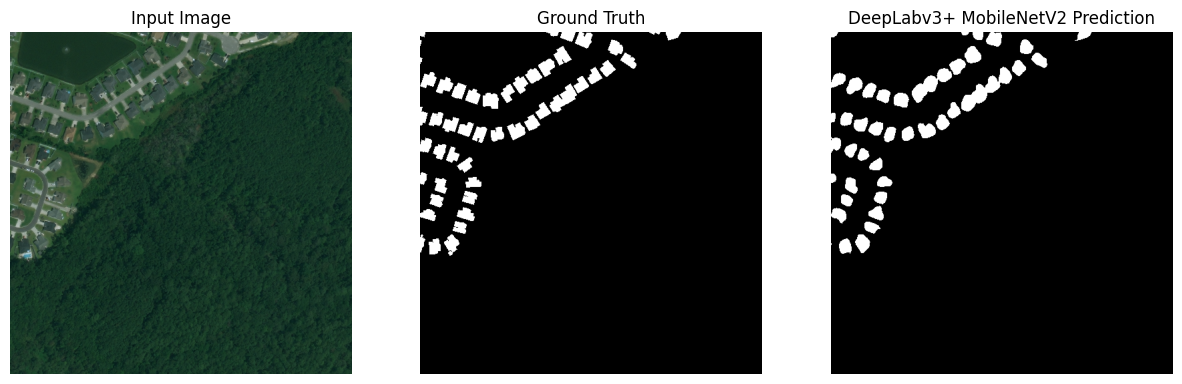

In [ ]:
# denormalize the display
img_vis = aug["image"].permute(1,2,0).cpu().numpy()
img_vis = (img_vis - img_vis.min()) / (img_vis.max() - img_vis.min())

gt_vis   = mask_tensor.squeeze().cpu().numpy()
pred_vis = pred.squeeze().cpu().numpy()

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(img_vis)
plt.title("Input Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt_vis, cmap="gray")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred_vis, cmap="gray")
plt.title("DeepLabv3+ MobileNetV2 Prediction")
plt.axis("off")

plt.show()
